In [ ]:
%reset

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
cwd = Path.cwd()
project_root = cwd.parent.parent.parent
data_path_stock = project_root / "Empirical" / "data" / "stock_data.csv"
data = pd.read_csv(data_path_stock)
data_path_bond = project_root / "Empirical" / "data" / "DTB3.csv"
bond_returns = pd.read_csv(data_path_bond)

**Variable Descriptions**

(dvrated) Indicated Annual Dividend Rate - Daily
(divsppaydate) Special Cash Dividends - Daily Payment Date
(divd) Cash Dividends - Daily

In [ ]:
# convert datadate to datetime
data["datedate"] = pd.to_datetime(data["datadate"])
bond_returns["observation_date"] = pd.to_datetime(bond_returns["observation_date"])

In [ ]:
# compute daily returns
data['prccd'] = data['prccd'].bfill()
data["return"] = (data["prccd"] - data["prccd"].shift(1)) / data["prccd"].shift(1)
data['return'] = data['return'].fillna(0)
# convert datadate to datetime
data["datedate"] = pd.to_datetime(data["datadate"])

In [ ]:
# replace missing values with previous available value
data["dvrated"] = data.groupby("GVKEY")["dvrated"].bfill()
data["dvrated"] = data["dvrated"].fillna(0)
data["dividend_yield"] = data["dvrated"] / data["prccd"].shift(1)

In [ ]:
# check for outliers, remove all observations with returns larger than 100% or lower than -95%
outliers_h = data[data['return'] > 2]['GVKEY'].unique()
outliers_l = data[data['return'] < -0.95]['GVKEY'].unique()
data = data[data['datedate'] >= '2010-02-01']
data = data[data['datedate'] < '2025-01-01']
data = data[~data['GVKEY'].isin(outliers_h)]
data = data[~data['GVKEY'].isin(outliers_l)]

In [ ]:
# approximately calculate daily bond returns from annualized rates
bond_returns['DTB3_daily'] = (1 + bond_returns['DTB3']) ** (1/360) - 1

# replace missing values with previous available value
bond_returns['DTB3_daily'] = bond_returns['DTB3_daily'].bfill()

In [ ]:
# add bond returns to stock data
data = pd.merge(data, bond_returns[['observation_date','DTB3_daily']], left_on='datedate', right_on='observation_date', how='left')
# calculate excess returns
data['excess_return'] = data['return'] - data['DTB3_daily']

In [ ]:
# calculate mean return and sd of returns for each day
summary_stats_time = data.groupby('datedate').agg({
    'return': ['mean', 'std'],
    'dividend_yield': ['mean', 'std'],
    'excess_return': ['mean', 'std']
})


# calculate mean return and sd of returns for each day
summary_stats_stock = data.groupby('GVKEY').agg({
    'return': ['mean', 'std'],
    'dividend_yield': ['mean', 'std'],
    'excess_return': ['mean', 'std']
})

summary_stats_bonds = bond_returns.agg({
    'DTB3': ['mean', 'std']})

In [ ]:
# calculate autocorrelation of returns, dividend yields for each stock
autocorrs = data.groupby('GVKEY')['dividend_yield'].apply(lambda x: x.dropna().autocorr(lag=1)).reset_index(name='dividend_yield_autocorr')

In [21]:
data['dividend_yield_lag1'] = data['dividend_yield'].shift(1)
clean_data = data[['GVKEY','excess_return', 'dividend_yield', 'dividend_yield_lag1']].dropna()

In [25]:
# run rgressions of excess returns on dividend yields for each stock


reg_results = clean_data.groupby('GVKEY').apply(
    lambda x: (
        lambda model: pd.Series({
            'c1': model.params['const'],
            'c2': model.params['dividend_yield'],
            'r_squared': model.rsquared
        })
    )(sm.OLS(   
        x['excess_return'].dropna(),
        sm.add_constant(x['dividend_yield'].dropna()
    )).fit())
)


avg_coefficients = reg_results.mean()


c2 = reg_results['c2']
c2_clean = c2.drop(c2.idxmax())
c2_clean = c2_clean.drop(c2.nsmallest(2).index)

C:\Users\jonat\AppData\Local\Temp\ipykernel_26640\1709539858.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reg_results = clean_data.groupby('GVKEY').apply(


In [ ]:
# correlation of return, excess_return and dividend_yield
correlation_matrix = summary_stats_time.xs('mean', axis=1, level = 1).corr()

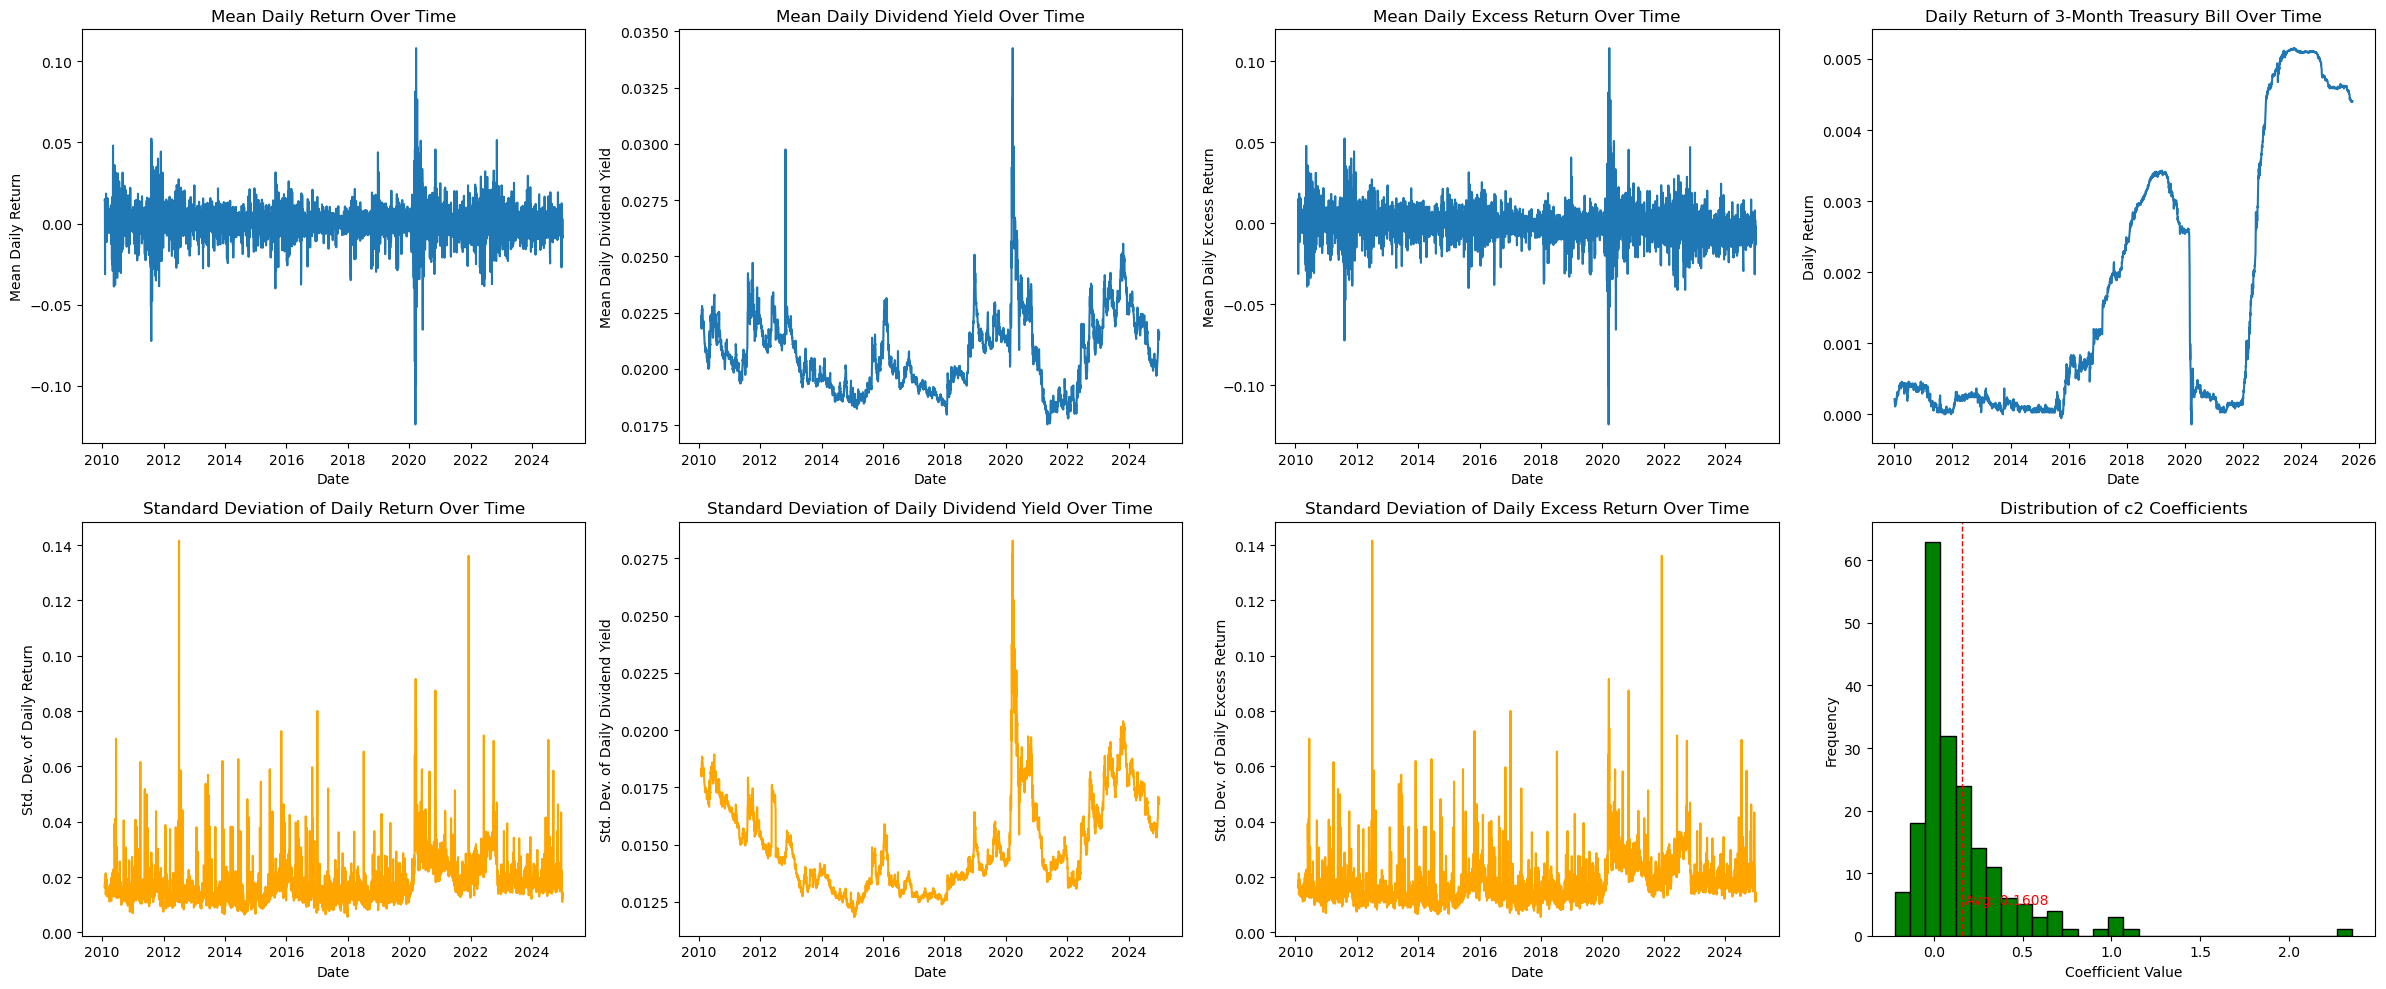

In [27]:
fig, axs = plt.subplots(2, 4, figsize=(24, 10))

# --- TOP ROW: Means / Levels ---
# 1. Mean daily return
axs[0, 0].plot(summary_stats_time.index, summary_stats_time['return']['mean'])
axs[0, 0].set_title('Mean Daily Return Over Time')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Mean Daily Return')

# 2. Mean daily dividend yield
axs[0, 1].plot(summary_stats_time.index, summary_stats_time['dividend_yield']['mean'])
axs[0, 1].set_title('Mean Daily Dividend Yield Over Time')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Mean Daily Dividend Yield')

# 3. Mean daily excess return
axs[0, 2].plot(summary_stats_time.index, summary_stats_time['excess_return']['mean'])
axs[0, 2].set_title('Mean Daily Excess Return Over Time')
axs[0, 2].set_xlabel('Date')
axs[0, 2].set_ylabel('Mean Daily Excess Return')

# --- BOTTOM ROW: Volatilities / Fluctuations ---
# 5. Std dev of daily return
axs[1, 0].plot(summary_stats_time.index, summary_stats_time['return']['std'], color='orange')
axs[1, 0].set_title('Standard Deviation of Daily Return Over Time')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Std. Dev. of Daily Return')

# 6. Std dev of daily dividend yield
axs[1, 1].plot(summary_stats_time.index, summary_stats_time['dividend_yield']['std'], color='orange')
axs[1, 1].set_title('Standard Deviation of Daily Dividend Yield Over Time')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Std. Dev. of Daily Dividend Yield')

# 7. Std dev of daily excess return
axs[1, 2].plot(summary_stats_time.index, summary_stats_time['excess_return']['std'], color='orange')
axs[1, 2].set_title('Standard Deviation of Daily Excess Return Over Time')
axs[1, 2].set_xlabel('Date')
axs[1, 2].set_ylabel('Std. Dev. of Daily Excess Return')

# 8. Daily 3M T-Bill return
axs[0, 3].plot(bond_returns['observation_date'], bond_returns['DTB3_daily'])
axs[0, 3].set_title('Daily Return of 3-Month Treasury Bill Over Time')
axs[0, 3].set_xlabel('Date')
axs[0, 3].set_ylabel('Daily Return')

axs[1, 3].hist(c2_clean.dropna(), bins=30, color='green', edgecolor='black')
axs[1, 3].set_title('Distribution of c2 Coefficients')
axs[1, 3].set_xlabel('Coefficient Value')
axs[1, 3].set_ylabel('Frequency')
axs[1, 3].axvline(avg_coefficients['c2'], color='red', linestyle='dashed', linewidth=1)
axs[1, 3].text(avg_coefficients['c2']*1.1, 5, f'Avg: {avg_coefficients["c2"]:.4f}', color='red')  

plt.tight_layout()
plt.show()